# Kalman Filterin' 2: Electric Boogaloo
### SCJ Robertson

An Extended Kalman Filter (EKF) will be used to track a golf ball in cartesain coordinates. The measurements are a range-Doppler map for each of EMSS's detectors at a given time instance. The golf ball's position in cartesian coordinates is then determined using multilateration. Multilateration ensures the measurement model is non-linear forcing the use of the EKF, even if the system model is assumed to be linear.

As of yet there is no actual measured data, therefore the Range-Doppler measurements must be simulated.

### Summary of notebook:

* No actual Kalman Filtering here yet, just the following overhead:
    * A relatively accurate model for simulating the golf ball trajectory.
    * Simulation of range-Doppler measurements.
    * Multilateration - finding position in $\mathscr{R}^{3}$ from range measurements

In [8]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pylab as plt
from mpl_toolkits import mplot3d
from calc_traj import calc_traj
from range_doppler import range_doppler, multilateration
from util import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Golf ball flight dynamics 
The following section documents the development of a model for golf ball flight dynamics, it is largely based off EMSS's own investigations.

<img src="forces.png" scale=0.25>
<center> <b> Figure 1: Force diagram of a golf ball. $\mathbf{v}$ is the velocity vector and not a force. </b> </center>

Ignoring all external influences, Figure 1 depicts the principle forces acting a golf ball in flight. These forces are assumed to be those with the largest influence on the golf ball's trajectory. The forces are:

* $\mathbf{F}_D$: The drag force is opposed to the velocity $\mathbf{v}$, its magnitude for a given component is determined by $$F_{D} = \frac{1}{2} C_{D} \rho A |v|^{2}$$ $\rho$ is the density of the air and $A$ golf ball's cross sectional area. The drag coefficient, $C_{D}$, is itself a function of both the ball's linear and angular speed. 

* $\mathbf{F}_{L}$: The lift force is perpendicular to linear and rotational velocity, thus determined by a cross product. Its magnitude for a given component is determined by $$F_{L} = \frac{1}{2} C_{L} \rho A |v|^{2}$$ The lift coefficient, $C_{L}$, is itself a function of both the ball's linear and angular speed. 

* $m\mathbf{g}$: Gravity, it goes downwards.

Applying Newton's second law, $$\mathbf{a} = \frac{1}{m} \sum \mathbf{F}$$ and simplifying results in the following system of ODES:

$$ \begin{eqnarray} 
\frac{d^2x}{dt^2} &=& -\frac{\rho A |v|}{2m} (C_{D}v_{x} - C_{L}[\frac{\omega_y}{|\omega|}v_z - \frac{\omega_y}{|\omega|}v_y])  \\  
\frac{d^2y}{dt^2} &=& -g -\frac{\rho A |v|}{2m} (C_{D}v_{y} - C_{L}[\frac{\omega_z}{|\omega|}v_x - \frac{\omega_x}{|\omega|}v_z]) \\ 
\frac{d^2z}{dt^2} &=& -\frac{\rho A |v|}{2m} (C_{D}v_{z} - C_{L}[\frac{\omega_x}{|\omega|}v_y - \frac{\omega_y}{|\omega|}v_x]) 
\end{eqnarray}$$

This system assumes a linear rate of decay for the spin, which is described the following system of equations:

$$ \begin{eqnarray}
\frac{d\omega_x}{dt} &=& -SRD \frac{\omega_x |v|}{R} \\
\frac{d\omega_y}{dt} &=& -SRD \frac{\omega_y |v|}{R} \\
\frac{d\omega_z}{dt} &=& -SRD \frac{\omega_z |v|}{R}
\end{eqnarray} $$

$R$ is the radius of the golf ball.

<b> Remark </b>: <i> It is convention set the $y$-axis as elevation allowing the spin rate to be positive for back spin . This leads to a constant interchange of $y$ and $z$ axes for launch and direction angle calculations; however; this can be abstracted away.</i>

Here SRD, $C_{D}$ and $C_{L}$ are given by their empirical equations:

$$ \begin{eqnarray}
C_{D} &=& C_{D1} + C_{D2} + C_{D3} \sin(\pi [R_{e} - A_{1}]/A_{2}) \\
R_{e} &=& \frac{\rho |v| L}{\mu} \\
C_{L} &=& C_{L1} S^{0.45} \\
SRD &=& R_{1} S \\
S &=& \frac{ |\omega| R}{|v|}
\end{eqnarray} $$

It can be seen the drag coefficient depends on the object's shape and Reynolds number, $R_{e}$, and the lift coefficient on the spin rate factor, $S$. The values of the constants $C_{D1}$, $C_{D2}$, $C_{L1}$, $\mu$, $R$, $R_{1}$, $A_{1}$ and $A_{2}$ can be found in the <b>calc_traj.py</b> module.

<b> Remark </b>: <i> EMSS's documentation shows the model is reasonably accurate when compared to the PGA tour measurements; however it requires the subtle tweaking of several parameters which aren't mentioned in the documentation. This model will not be used as the Kalman filter's system model but it will be used to generate the golf ball's simualted trajectory. This trajectory will then be used to simulate range-Doppler measurements which via multilateration will be converted back to its cartesian coordinates.</i>


### Simulation

The system of ODES can be solved using the function <b>calc_traj</b> in the <b>calc_traj.py</b> module. The initial conditions for the various clubs can be found in the <i>clubs.csv</i> file or the table below. The table and plot below document the simulation's results.

In [9]:
names, p0, v0, w0 = load_clubs('clubs.csv')

N = len(names)
t = np.arange(0, 12, 0.001)

<table> 

    <tr>
        <th>Club</th>
        <th>Launch angle ($^{\circ}$)</th>
        <th>Speed (m/s)</th>
        <th>Spin (RPM)</th>
        <th>Maximum height (m)</th>
        <th>Simulated height (m)</th>
        <th>Maximum carry (m)</th>
        <th>Simulated carry (m)</th>
    </tr>
    
    <tr>
        <th>Driver</th>
        <th>10.9</th>
        <th>74.2</th>
        <th>2686</th>
        <th>29.2</th>
        <th>31.37</th>
        <th>251.46</th>
        <th>240.79</th>
    </tr>
    
    <tr>
        <th>3-Wood</th>
        <th>9.2</th>
        <th>70.2</th>
        <th>3655</th>
        <th>27.43</th>
        <th>28.81</th>
        <th>222.20</th>
        <th>230.44</th>
    </tr>
    
    <tr>
        <th>5-Wood</th>
        <th>9.4</th>
        <th>67.5</th>
        <th>4350</th>
        <th>28.35</th>
        <th>29.77</th>
        <th>210.31</th>
        <th>224.44</th>
    </tr>
    
    <tr>
        <th>Hybrid</th>
        <th>10.2</th>
        <th>63.1</th>
        <th>4360</th>
        <th>24.69</th>
        <th>28.22</th>
        <th>193.85</th>
        <th>210.82</th>
    </tr>
    
    <tr>
        <th>3 Iron</th>
        <th>10.2</th>
        <th>63.1</th>
        <th>4360</th>
        <th>24.69</th>
        <th>28.22</th>
        <th>193.85</th>
        <th>210.82</th>
    </tr>
    
    <tr>
        <th>4 Iron</th>
        <th>11.0</th>
        <th>60.9</th>
        <th>4836</th>
        <th>25.60</th>
        <th>27.71</th>
        <th>185.62</th>
        <th>203.88</th>
    </tr>
    
    <tr>
        <th>5 Iron</th>
        <th>12.1</th>
        <th>58.7</th>
        <th>5361</th>
        <th>28.35</th>
        <th>32.94</th>
        <th>177.39</th>
        <th>198.87</th>
    </tr>
    
    <tr>
        <th>6 Iron</th>
        <th>14.1</th>
        <th>56.4</th>
        <th>6231</th>
        <th>27.43</th>
        <th>36.34</th>
        <th>167.33</th>
        <th>190.14</th>
    </tr>
    
    <tr>
        <th>7 Iron</th>
        <th>16.3</th>
        <th>53.3</th>
        <th>7097</th>
        <th>29.26</th>
        <th>33.33</th>
        <th>157.28</th>
        <th>169.26</th>
    </tr>
    
    <tr>
        <th>8 Iron</th>
        <th>18.1</th>
        <th>51.1</th>
        <th>7998</th>
        <th>28.35</th>
        <th>33.33</th>
        <th>146.30</th>
        <th>156.38</th>
    </tr>
    
    <tr>
        <th>9 Iron</th>
        <th>20.4</th>
        <th>48.4</th>
        <th>8647</th>
        <th>27.43</th>
        <th>34.84</th>
        <th>135.33</th>
        <th>140.73</th>
    </tr>
    
    <tr>
        <th>PW</th>
        <th>24.2</th>
        <th>45.3</th>
        <th>9304</th>
        <th>26.52</th>
        <th>35.33</th>
        <th>124.36</th>
        <th>138.71</th>
    </tr>
    
    
</table>

<center> <b>Table 1: A comparison of PGA tour measurements and model outputs for various club types.</b> </center>

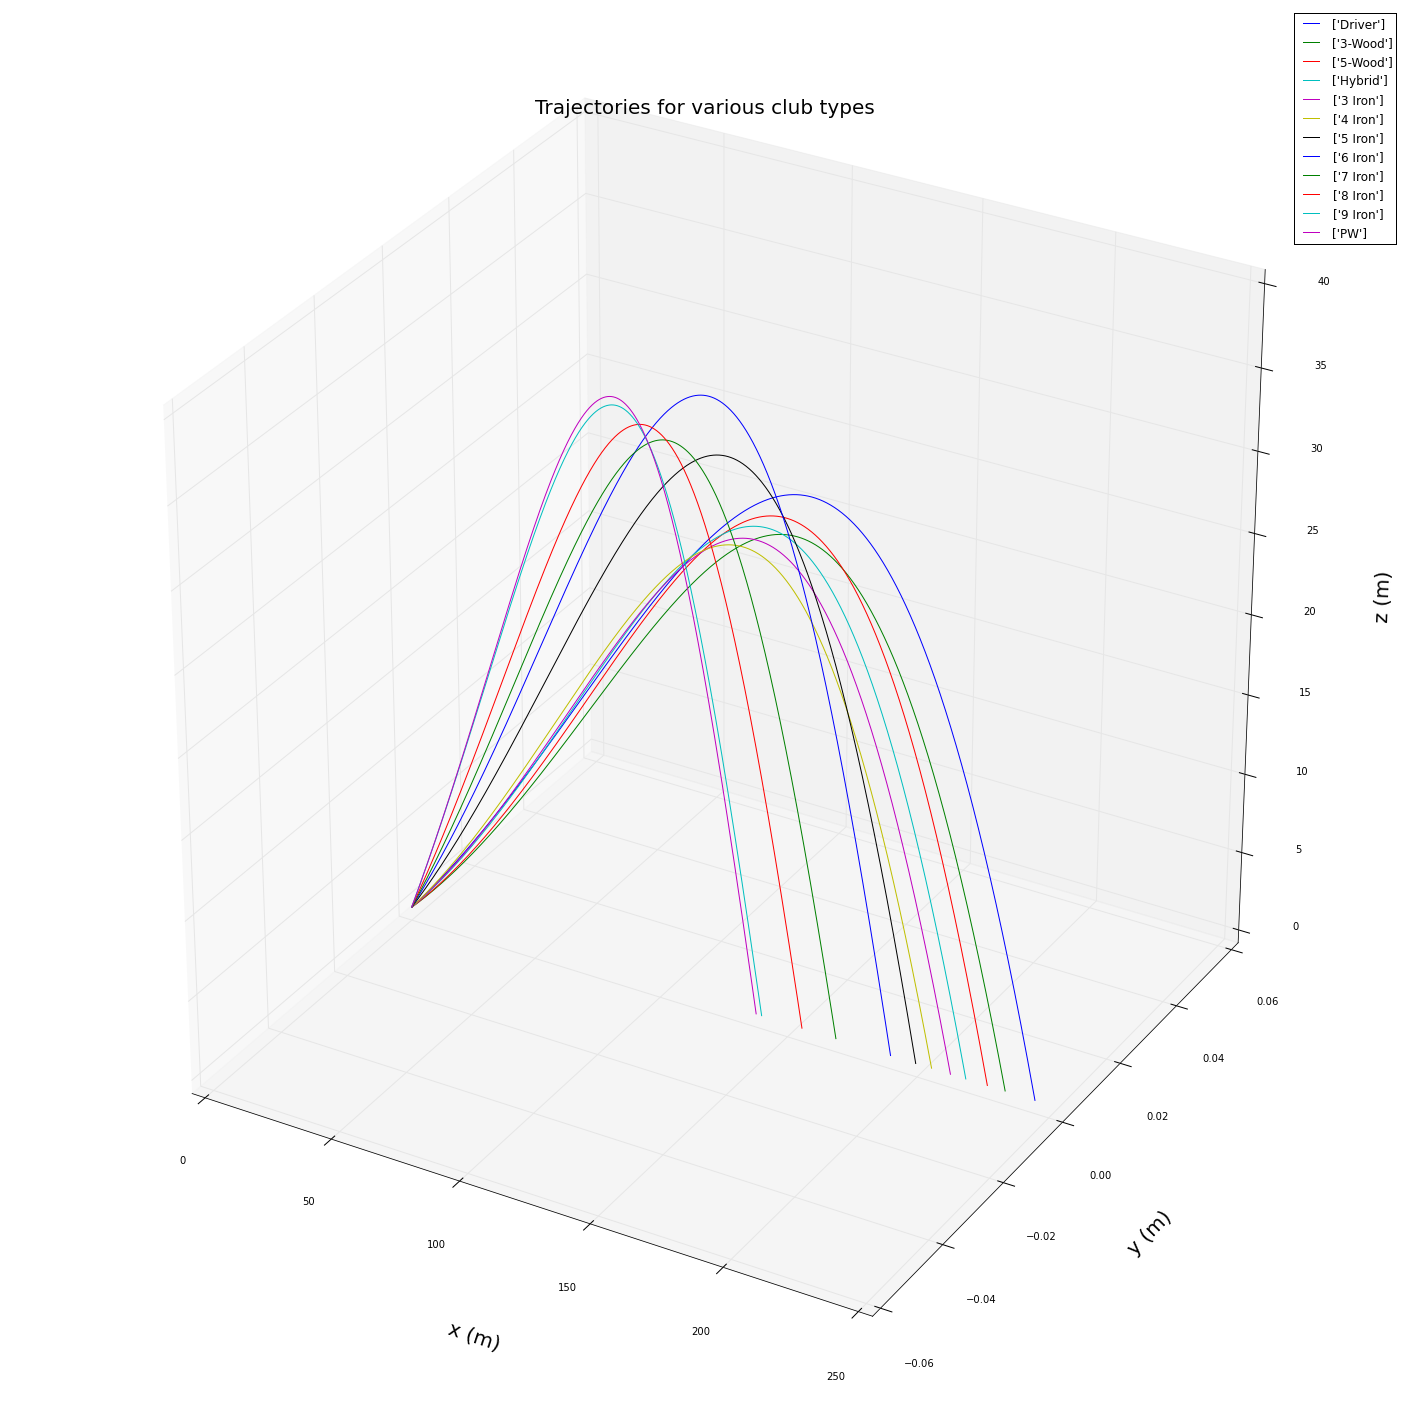

In [10]:
fig  = plt.figure(figsize=(25, 25))
ax = plt.axes(projection='3d')

for i in np.arange(0, N):
    _, f, _ = calc_traj(p0[i, :], v0[i, :], w0[i, :], t)
    ax.plot(f[:, 0], f[:, 1], f[:, 2])
  
ax.set_xlabel('x (m)', fontsize = '20')
ax.set_ylabel('y (m)', fontsize = '20')
ax.set_zlabel('z (m)', fontsize = '20')
ax.set_title('Trajectories for various club types', fontsize = '20')
ax.legend(names)
plt.show()

## The range-Doppler domain

Each of EMSS's sensors will output a range-Doppler map for a given time instance. Rather than simulate this in full, the Doppler information will be approximated by the ball's radial velocity seen by the sensor.

Using the simulation data, the position and velocity, $\mathbf{p}$ and $\mathbf{v}$, of the golf ball are known in full. Therefore the range seen by each sensor for each time step, $r_{k, i}$, is given by:

$$ \begin{eqnarray}
r_{k,i} = |\mathbf{p} - \mathbf{s}_k|
\end{eqnarray}$$

Where $\mathbf{s}_k$ is the known vector position of a given sensor. The radial velocity, $v_{k, i}$ seen by each sensor is determined as follows:
$$ \begin{eqnarray}
\mathbf{u}_{k,i} &=& \frac{\mathbf{p} - \mathbf{s}_k}{r_{k,i}} \\
v_{k, i} &=& \mathbf{u}_{k,i} \cdot \mathbf{v}_i
\end{eqnarray}$$

$\mathbf{u}_{k,i}$ is the unit vecotr from a sensor $k$ to the ball's current position.

### Simulation

The function <b> range_doppler </b> in <b> range_doppler.py </b> determines the range and radial velocity of the ball seen by each sensor. The range-Doppler plot below does not reflect an actual map as it plots the entire trajectory.

<b> Remark </b>: <i> Here I treated CPI (Coherent Processing Interval) as sensor sampling period, it seems to be what EMSS did. The sensor locations were also borrowed from EMSS's documentation, so I assume they reflect reality is some small way. Note the radial velocity is unneeded for the multilateration process, as it only requires range measurements, but was included for completeness. </i>

In [11]:
sensor_locations = np.array([[-10, 28.5, 1], [-15, 30.3, 3],
                             [200, 30, 1.5], [220, -31, 2],
                             [-30, 0, 0.5], [150, 10, 0.6]])
cpi = 40e-3
t_sim = np.arange(0, 12, cpi)
_, p, v = calc_traj(p0[0, :], v0[0, :], w0[0, :], t_sim)

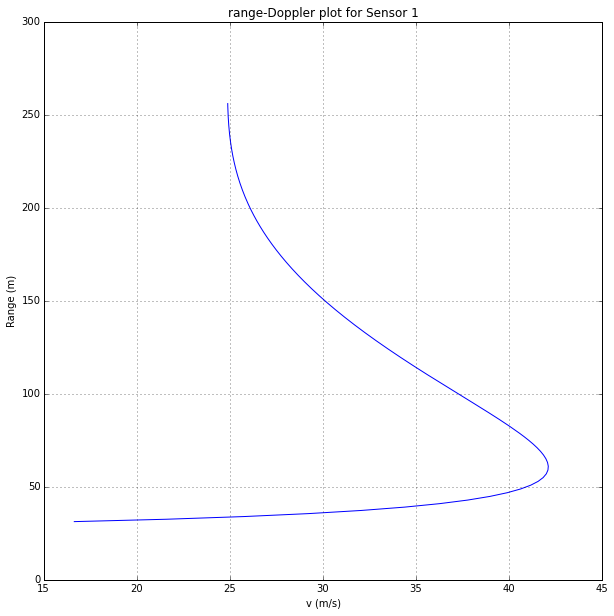

In [12]:
r_d = range_doppler(sensor_locations, p, v)

plt.figure(figsize= (10, 10))
plt.plot(r_d[0, :, 0], r_d[0, :, 1])
plt.xlabel('v (m/s)')
plt.ylabel('Range (m)')
plt.grid(True)
plt.title('range-Doppler plot for Sensor 1')

## Multilateration

There are two main techniques used for range based localization in sensor networks; trilateration and multilateration. Multilateration is derived from trilateration, but is capable of accurate localization when plagued by measurement noise. The following mathematical derivation is hoisted from F. Santos's <i> "Localization in Wireless Sensor Networks" (2008) </i>

### Trilateration

Trilateration is the process of finding a node in space, given certain known anchor points. Assume the positions of the anchor points are defined by vectors $\mathbf{n}_0, \mathbf{n}_1, \mathbf{n}_1 \in \mathscr{R}^2$. An unkown point, $\mathbf{p} \in \mathscr{R}^2$, is at a known distance $d_{i}$ from each anchor point, therefore:

$$ \begin{eqnarray}
d_{0}^{2}  &=& |\mathbf{p} - \mathbf{n}_{0}| &=& |\mathbf{p}|^{2} - 2 \mathbf{p} \cdot \mathbf{n}_{0} + |\mathbf{n}_{0}|^{2} \\
d_{1}^{2} &=&  |\mathbf{p} - \mathbf{n}_{1}| &=& |\mathbf{p}|^{2} - 2 \mathbf{p} \cdot \mathbf{n}_{1} + |\mathbf{n}_{1}|^{2} \\
d_{2}^{2} &=&  |\mathbf{p} - \mathbf{n}_{2}| &=& |\mathbf{p}|^{2} - 2 \mathbf{p} \cdot \mathbf{n}_{2} + |\mathbf{n}_{2}|^{2} \\
\end{eqnarray} $$
Subtracting the second and third equations from the first, yields:
$$ \begin{eqnarray}
2(\mathbf{n}_{1} - \mathbf{n}_{0}) \cdot \mathbf{p} = d_{0}^{2} - d_{1}^{2} - |\mathbf{n}_{0}|^{2} + |\mathbf{n}_{1}|^{2} \\
2(\mathbf{n}_{2} - \mathbf{n}_{0}) \cdot \mathbf{p} = d_{0}^{2} - d_{2}^{2} - |\mathbf{n}_{0}|^{2} + |\mathbf{n}_{2}|^{2} \\
\end{eqnarray} $$

Which can be rewritten in matrix form:

$$ \begin{eqnarray}
\mathbf{A} &=& \begin{bmatrix}
\mathbf{n}_{1} - \mathbf{n}_{0} \\
\mathbf{n}_{2} - \mathbf{n}_{0}
\end{bmatrix}_{2x2} \\
\mathbf{b} &=& \begin{bmatrix}
d_{0}^{2} - d_{1}^{2} - |\mathbf{n}_{0}|^{2} + |\mathbf{n}_{1}|^{2} \\
d_{0}^{2} - d_{2}^{2} - |\mathbf{n}_{0}|^{2} + |\mathbf{n}_{2}|^{2}
\end{bmatrix}_{2x1} \\
2 \mathbf{A} \cdot \mathbf{p} &=& \mathbf{b}
\end{eqnarray} $$

In general, to determine $\mathbf{p} \in \mathscr{R}^{N}$, $N+1$ anchor points are required $\mathbf{n}_{0}, ..., \mathbf{n}_{N} \in \mathscr{R}^{N}$. The geometric constraints are still satisfied with $|\mathbf{p} - \mathbf{n}_{i}|^2 = d_{i}^{2}$, $i = {0, 1, .. , N}$ and by a similiar process to that presented here will result in $N$ linear equations.

### Multilateration

Trialateration asssumes perfect measurements, whereas multilateration can account for error by making use of $M+1$ anchor points in $\mathscr{R}^{N}$, $M > N$. Using the similiar constraints to trilateration, $|\mathbf{p} - \mathbf{n}_{i}|^2= d_{i}^{2}$, $i = {0, 1, .. , M}$ a system of $M$ linear equations are derived:

$$ \begin{eqnarray}
\mathbf{A} &=& \begin{bmatrix}
\mathbf{n}_{1} - \mathbf{n}_{0} \\
\dots \\
\mathbf{n}_{M} - \mathbf{n}_{0}
\end{bmatrix}_{MxN} \\
\mathbf{b} &=& \begin{bmatrix}
d_{0}^{2} - d_{1}^{2} - |\mathbf{n}_{0}|^{2} + |\mathbf{n}_{1}|^{2} \\
\dots \\
d_{0}^{2} - d_{M}^{2} - |\mathbf{n}_{0}|^{2} + |\mathbf{n}_{M}|^{2}
\end{bmatrix}_{Mx1}\\
2 \mathbf{A} \cdot \mathbf{p} &=& \mathbf{b}
\end{eqnarray} $$

As defined $M > N$, therfore this system is overdetermined. Luckily a least squares solution provides an accurate approximate for $\mathbf{p}$, whereas trilateration will produce significant error. The best estimate of $\mathbf{p}$ can be provided by first using QR-decompostion:

$$ \begin{eqnarray}
2 \mathbf{A} \cdot \mathbf{p} &=& \mathbf{b} \\
2 \mathbf{QR} \cdot \mathbf{p} &=& \mathbf{b} \\
2 \mathbf{R} \cdot \mathbf{p} &=& \mathbf{Q}^{T} \cdot \mathbf{b}
\end{eqnarray}$$

Here $\mathbf{Q}$ is orthonormal, $\mathbf{Q}^{T} \mathbf{Q} = \mathbf{I}$. This manipulation minimizes the error, $|2\mathbf{A} \cdot \mathbf{p} - \mathbf{b}|$, providing the best estimate for $\mathbf{p}$.

## Implementation

The function <b>multilateration</b> in <b>range_doppler</b> determines the golf ball's coordinates in $\mathscr{R}^{3}$. The result for a single club is plotted below.

<b> Remark </b>: <i> As of yet no measurement noise has been introduced and this result should be equivalent to trilateration. As it can be seen from the derivation the clocks on each sensor must be synchronized, hopefully EMSS's system accounts for this.</i>

In [14]:
p_m = multilateration(sensor_locations, r_d[:, :, 1])

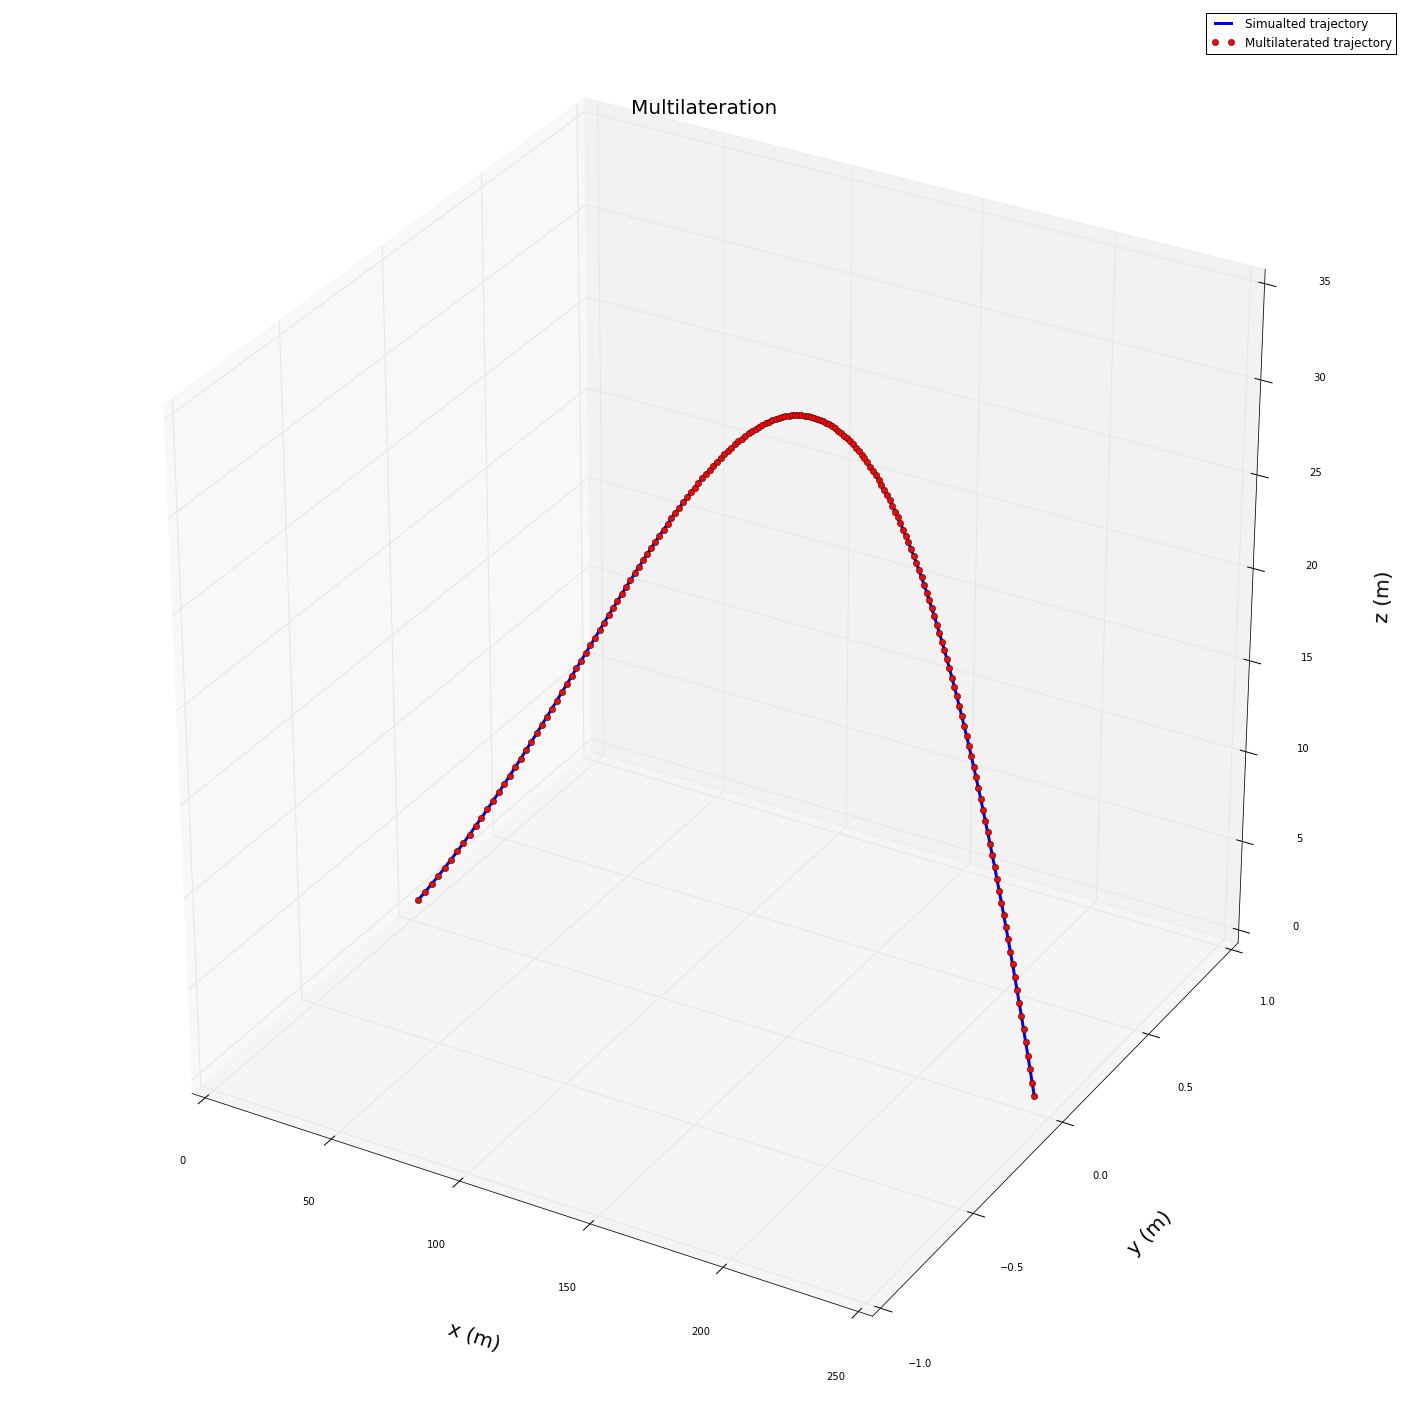

In [17]:
fig  = plt.figure(figsize=(25, 25))
ax = plt.axes(projection='3d')
ax.plot(p_m[:, 0], p_m[:, 1], p_m[:, 2], linewidth=3.0)
ax.plot(p[:, 0], p[:, 1], p[:, 2], 'or')
ax.set_xlabel('x (m)', fontsize = '20')
ax.set_ylabel('y (m)', fontsize = '20')
ax.set_zlabel('z (m)', fontsize = '20')
ax.set_title('Multilateration', fontsize = '20')
ax.set_ylim([-1, 1])
ax.legend(['Simualted trajectory', 'Multilaterated trajectory'])
plt.show()